In [1]:
### Author: Leonie Küchenhoff
### Date: December 10th 2022
### Purpose of script: 
### Search for bystander edits (edits in gRNA binding region)

In [4]:
# package import
import pandas as pd
import numpy as np
from config import basedir, outdir
import matplotlib.pyplot as plt
import seaborn as sns
import re
import logomaker
from ast import literal_eval
import os

In [ ]:
# directory settings
os.chdir(basedir)
outdir = str(outdir + '/bystander')
print('This base directory will be used:\n', basedir)

In [16]:
# sample names
names = ['028_pbs_R', '029_pbs_R', '030_nrch_R', '032_pbs_R', '033_nrch_R', '036_nrch_R',
       '011_pbs', '012_nrch', '013_nrch', '014_nrch', '279_spry', '321_pbs', '333_pbs', '450_spry', '283_spry']
# treatment in same order as sample names
base_editor = ['pbs', 'pbs','pbs','8e-NRCH', '8e-NRCH', '8e-NRCH',
            'pbs', '8e-NRCH', '8e-NRCH','8e-NRCH', 'max-SpRY', 'pbs', 'pbs', 'max-SpRY', 'max-SpRY']

# mutations in same order as sample names
mutation = ['r636q' if i[-1] == 'R' else 'p635l' for i in names]

In [19]:
# Use redi files 
path_redi = [f'bystander_edits/H{i}.all_edits.txtq' for i in names]

In [20]:
seq = 'GTATGGTCCAGAGCGGCCACGTTCTCGAAGTCCAATGAGCCGA'

In [21]:
redi_files = {}
bystanders = {}
for i,j,k,l in zip(names, path_redi,mutation, base_editor): 
    '''
    for loop to read redi files and add some information
    '''   
    file = pd.read_csv(j, sep = '\t')
    count = file['BaseCount[A,C,G,T]'].apply(lambda x: literal_eval(str(x)))
    reads = np.stack(count, axis=0 )
    file[['A','C', 'G', 'T']] = reads
    file['mutation'] = k
    file['treatment'] = l
    file = file[(file['Position']>=53843223)&(file['Position']<=53843265)]
    file = file.set_index('Position')
    file['group'] = file['mutation'] +'_'+ file['treatment'] 
    bystanders[i] = file

In [22]:
def ratio(df):
    '''
    get allele frequency per base and position
    '''
    df_r = (df.T / df.T.sum()).T
    return df_r


In [26]:
# summarize files from same condition (same mutation, same treatment) and calculate ratio of each read
p636q_pbs  = bystanders['028_pbs_R'][['A','C','G','T']].add(bystanders['029_pbs_R'][['A','C','G','T']],axis = 'index', fill_value=0).add(bystanders['032_pbs_R'][['A','C','G','T']],axis = 'index', fill_value=0)
p636q_pbs = ratio(p636q_pbs)
p636q_pbs.to_csv(f'{outdir}/p363q_pbs.txt')

p635l_max = bystanders['279_spry'][['A','C','G','T']].add(bystanders['450_spry'][['A','C','G','T']],axis = 'index', fill_value=0).add(bystanders['283_spry'][['A','C','G','T']],axis = 'index', fill_value=0)
p635l_max = ratio(p635l_max)
p635l_max.to_csv(f'{outdir}/p635l_max.txt')

p635l_8e = bystanders['012_nrch'][['A','C','G','T']].add(bystanders['013_nrch'][['A','C','G','T']],axis = 'index', fill_value=0).add(bystanders['014_nrch'][['A','C','G','T']],axis = 'index', fill_value=0)
p635l_8e = ratio(p635l_8e)
p635l_8e.to_csv(f'{outdir}/p635l_8e.txt')

p636q_8e = bystanders['030_nrch_R'][['A','C','G','T']].add(bystanders['033_nrch_R'][['A','C','G','T']],axis = 'index', fill_value=0).add(bystanders['036_nrch_R'][['A','C','G','T']],axis = 'index', fill_value=0)
p636q_8e = ratio(p636q_8e)
p636q_8e.to_csv(f'{outdir}/p636q_8e.txt')

p635l_pbs = bystanders['011_pbs'][['A','C','G','T']].add(bystanders['321_pbs'][['A','C','G','T']],axis = 'index', fill_value=0).add(bystanders['333_pbs'][['A','C','G','T']],axis = 'index', fill_value=0)
p635l_pbs = ratio(p635l_pbs)
p635l_pbs.to_csv(f'{outdir}/p635l_pbs.txt')

In [27]:
# plotting settings
plt.rcParams.update({'font.size':18, 'text.usetex': False,
"svg.fonttype": 'none'})

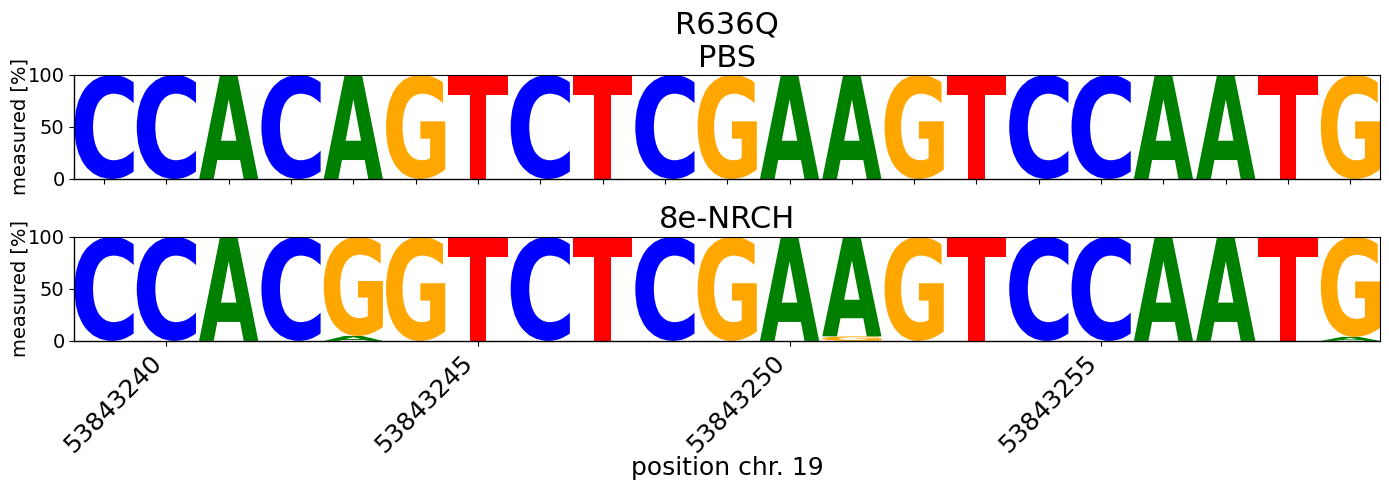

In [28]:
plt.style.use('seaborn-colorblind')
plt.style.use('default')
fig, ax = plt.subplots(2, figsize = (14,5))

crp_logo = logomaker.Logo(p636q_pbs[16:37]*100,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          ax = ax[0])

crp_logo1 = logomaker.Logo(p636q_8e[16:37]*100,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                           ax=ax[1])

# style using Logo methods
crp_logo.style_xticks(color = 'white', size = 1)
crp_logo1.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo1.style_xticks(rotation=45,  anchor=0, spacing = 5, ha = 'right', size = 18)


ax[0].set_title('R636Q\nPBS', size = 22)
ax[1].set_title('8e-NRCH', size = 22)

# style using Axes methods
crp_logo1.ax.set_ylabel("measured [%]", labelpad=-1, size = 14)
crp_logo1.ax.set_xlabel("position chr. 19", labelpad=-1, size =18)
crp_logo.ax.set_ylabel("measured [%]", labelpad=-1, size = 14)

ax[0].tick_params(axis='y', which='minor', labelsize=14)
ax[0].tick_params(axis='y', which='major', labelsize=14)
ax[1].tick_params(axis='y', which='minor', labelsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=14)


fig.tight_layout()
#plt.savefig(f'{outdir}/p636q.pdf', bbox_inches = 'tight')

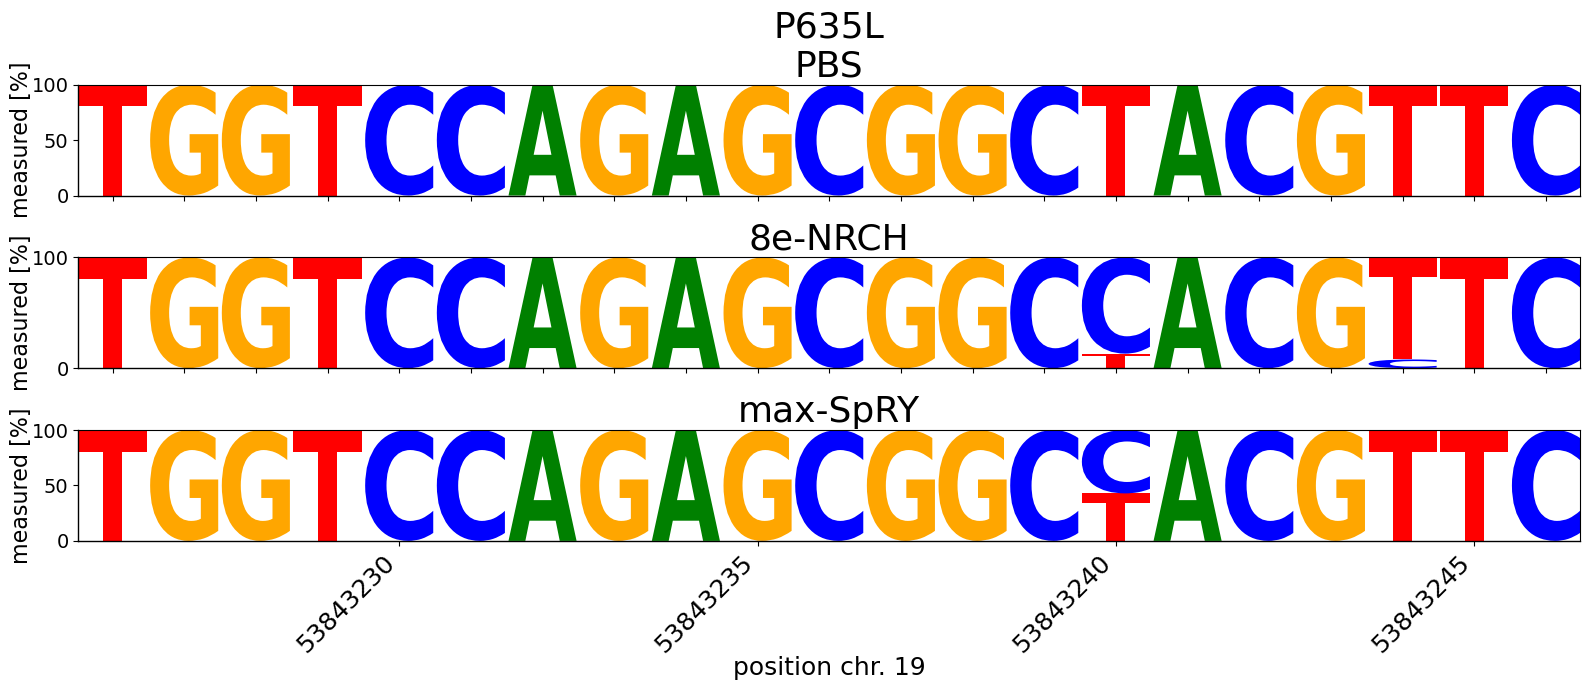

In [29]:
plt.style.use('seaborn-colorblind')
plt.style.use('default')
fig, ax = plt.subplots(3, figsize = (16,7))
crp_logo = logomaker.Logo(p635l_pbs[3:24]*100,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          ax = ax[0])
                          
crp_logo1 = logomaker.Logo(p635l_8e[3:24]*100,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          ax = ax[1])

crp_logo2 = logomaker.Logo(p635l_max[3:24]*100,
                          shade_below=.5,
                          fade_below=.5,
                          font_name='Arial Rounded MT Bold',
                          ax = ax[2])


crp_logo.style_xticks(color = 'white', size = 1)
crp_logo1.style_xticks(color = 'white', size = 1)
crp_logo2.style_xticks(rotation=45,  anchor=0, spacing = 5, ha = 'right', size = 18)

crp_logo.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo1.style_spines(spines=['left', 'bottom'], visible=True)
crp_logo2.style_spines(spines=['left', 'bottom'], visible=True)

# style using Axes methods
crp_logo1.ax.set_ylabel("measured [%]", labelpad=-1, size = 16)
crp_logo2.ax.set_xlabel("position chr. 19", labelpad=-1, size = 18)

crp_logo.ax.set_ylabel("measured [%]", labelpad=-1, size = 16)
crp_logo2.ax.set_ylabel("measured [%]", labelpad=-1, size = 16)



ax[0].tick_params(axis='y', which='minor', labelsize=14)
ax[0].tick_params(axis='y', which='major', labelsize=14)
ax[1].tick_params(axis='y', which='minor', labelsize=14)
ax[1].tick_params(axis='y', which='major', labelsize=14)
ax[2].tick_params(axis='y', which='minor', labelsize=14)
ax[2].tick_params(axis='y', which='major', labelsize=14)
ax[0].set_title('P635L\nPBS', size = 26)
ax[1].set_title('8e-NRCH', size = 26)
ax[2].set_title('max-SpRY', size = 26)


fig.tight_layout()
#plt.savefig(f'{outdir}/p635l.pdf', bbox_inches = 'tight')